# **Data Cleaning and Model Creation**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import MinMaxScaler
from tabulate import tabulate
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,f1_score
import joblib

In [ ]:
data = pd.read_csv('train.csv')
data.head()

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


In [ ]:
# removing weaK predictors
data = data.drop(columns=['hospital_number', 'total_protein', 'lesion_1', 'lesion_2', 'lesion_3','abdominal_distention', 'rectal_exam_feces', 'abdomen', 'surgical_lesion', 'cp_data','peristalsis'])
data.head()

,id,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,packed_cell_volume,abdomo_appearance,abdomo_protein,outcome
0,0,yes,adult,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,depressed,slight,less_1_liter,6.5,57.0,serosanguious,3.4,died
1,1,yes,adult,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,mild_pain,none,more_1_liter,2.0,33.0,serosanguious,2.0,euthanized
2,2,yes,adult,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,extreme_pain,slight,none,3.5,37.0,serosanguious,3.4,lived
3,3,yes,adult,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,mild_pain,slight,more_1_liter,2.0,53.0,cloudy,3.9,lived
4,4,no,adult,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,alert,slight,less_1_liter,7.0,47.0,cloudy,2.6,lived


In [ ]:
#  seperating columns based on dtypes
num_cols = []
for i in data.columns:
  if data[i].dtype != 'object' and i != 'id': # dont need id
    num_cols.append(i)

cat_cols = []
for i in data.columns:
  if data[i].dtype == 'object':
    cat_cols.append(i)

print("Numeric Columns:", num_cols)
print("Categorical Columns:", cat_cols)

Numeric Columns: ['rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 'abdomo_protein']
Categorical Columns: ['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'nasogastric_tube', 'nasogastric_reflux', 'abdomo_appearance', 'outcome']


## **Data cleaning and Preperation for ML**

###**Plan for addressing missing values:**


---


**Temp of extremities:**
It has 39 missing vals. Since its categorical, we'll impute mode.

**Peripheral Pulse:**
It has 60 missing vals. Since its categorical, we'll impute mode.

**Mucous Membrane:**
It has 21 missing vals. Since its categorical, we'll impute mode.

**Capillary refill time:**
It has 6 missing vals. Since its categorical, we'll impute mode. Because there are so few missing values I could've just removed them, but this feature has high predictive power, so i want to preserve it.

**Pain:**
It has 44 missing vals. Since its categorical, we'll impute mode.

**Peristalsis:**
It has 20 missing vals. Earlier we stated that this feature had weak predicting power so im just going to remove it.

**Abdominal Distension:**
It has 23 missing vals. Earlier we stated that this feature had weak predicting power so im just going to remove it.

**Nasogastric Tube:**
It has 80 missing values. It is only a moderate predictor. My options are to impute with 'unknown', remove, or create a new category that reflects the missing vales. I don't want to lose data so i wont remove, but this feature is not that important so creating a new category is not essential. Becuase of this, I will impute with 'unknown'.

**Nasogastric Reflux:**
It has 21 missing values. Same as above, so I will impute with 'unknown'.

**Rectal Exam:**
It has 190 missing values. This is alot, and since we've already established that this feature has very weak predicting power, I'm going to remove this column altogether.

**Abdomen:**
It has 213 missing values. Its the same case as above.This is alot, and since we've already established that this feature has very weak predicting power, I'm going to remove this column altogether.

**Abdomo Appearance:**
It has 48 missing vals. Since its categorical, we'll impute mode.


---



In [ ]:
#already removed the weak cols

#features to impute with mode
to_impute_with_mode = ['temp_of_extremities','peripheral_pulse','mucous_membrane','capillary_refill_time', 'pain', 'abdomo_appearance']
for i in to_impute_with_mode:
    data[i] = data[i].fillna(data[i].mode()[0])

#features to impute with 'unknown'
to_impute_with_unknown = ['nasogastric_tube', 'nasogastric_reflux']
for i in to_impute_with_unknown:
    data[i] = data[i].fillna('Unknown')

data.isna().sum()


,0
id,0
surgery,0
age,0
rectal_temp,0
pulse,0
respiratory_rate,0
temp_of_extremities,0
peripheral_pulse,0
mucous_membrane,0
capillary_refill_time,0


In [ ]:
# basic func using iqr to identify and remove outliers
def remove_outliers(data, numerical_features):
    data_cleaned = data.copy()
    for feature in numerical_features:
        Q1 = data_cleaned[feature].quantile(0.25)
        Q3 = data_cleaned[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data_cleaned = data_cleaned[(data_cleaned[feature] >= lower_bound) & (data_cleaned[feature] <= upper_bound)]
    return data_cleaned

# func to give me info abt my outliers
def analyze_outliers(data, numerical_features):
    summary = []
    for feature in numerical_features:
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]
        summary.append({
            "Feature": feature,
            "Lower Bound": lower_bound,
            "Upper Bound": upper_bound,
            "Outlier Count": len(outliers)
        })
    return pd.DataFrame(summary)

# check outliers before removal
outliers_before = analyze_outliers(data, num_cols)
print("Outliers before removal:")
print(outliers_before)


Outliers before removal:
                 Feature  Lower Bound  Upper Bound  Outlier Count
0            rectal_temp        36.60        39.80             72
1                  pulse       -17.50       170.50              4
2       respiratory_rate        -9.00        63.00             57
3  nasogastric_reflux_ph        -4.00        12.00              0
4     packed_cell_volume        22.00        78.00              0
5         abdomo_protein        -1.45         7.75             19


In [ ]:
# acutally removing them
data_cleaned = remove_outliers(data, num_cols)

# Check outliers after removal
outliers_after = analyze_outliers(data_cleaned, num_cols)
print("Outliers after removal:")
print(outliers_after)

# Save cleaned data if needed
data_cleaned.to_csv('cleaned_train.csv', index=False)

Outliers after removal:
                 Feature  Lower Bound  Upper Bound  Outlier Count
0            rectal_temp        36.75        39.55             20
1                  pulse       -14.00       162.00              0
2       respiratory_rate       -14.00        66.00              0
3  nasogastric_reflux_ph        -3.25        10.75              0
4     packed_cell_volume        24.00        72.00             15
5         abdomo_protein        -0.85         6.75             14


It looks like the columns : rectal_temp, packed_cell_volume, and abdomo_protein, all have outliers even after I handled them.

Lets refer back to my horse health research to see if there is a reason for this.

*   The average rectal temp of horses is 37.5 to 38.6 celcius.
*   The average packed cell volume of horeses is 30%-45%.
*   The average abdomo protein amount is less than 2.5 g/dL.

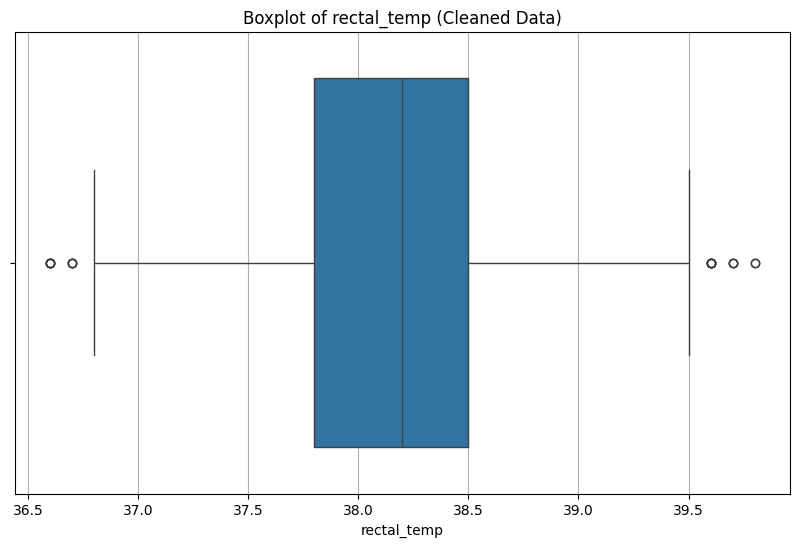

Feature: rectal_temp
  Lower Bound: 36.74999999999999
  Upper Bound: 39.550000000000004
  Outlier Values:
282     39.6
309     39.8
334     39.6
437     39.7
459     39.6
483     36.6
492     36.7
537     36.7
589     36.6
645     36.7
719     39.8
749     39.6
773     36.6
856     39.6
886     36.6
1074    36.6
1119    39.7
1134    36.7
1171    39.6
1201    39.7




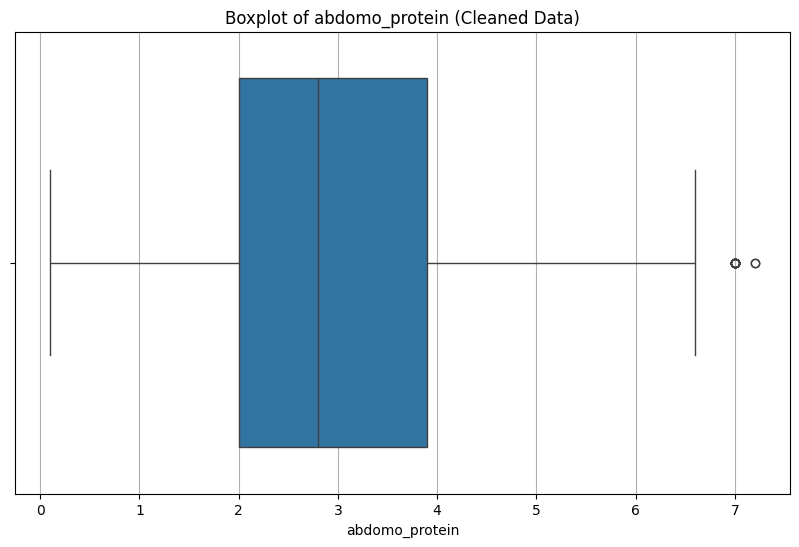

Feature: abdomo_protein
  Lower Bound: -0.8499999999999996
  Upper Bound: 6.75
  Outlier Values:
121     7.0
244     7.0
247     7.0
297     7.0
581     7.0
594     7.0
694     7.0
696     7.2
819     7.0
931     7.0
960     7.2
1018    7.0
1021    7.0
1232    7.0




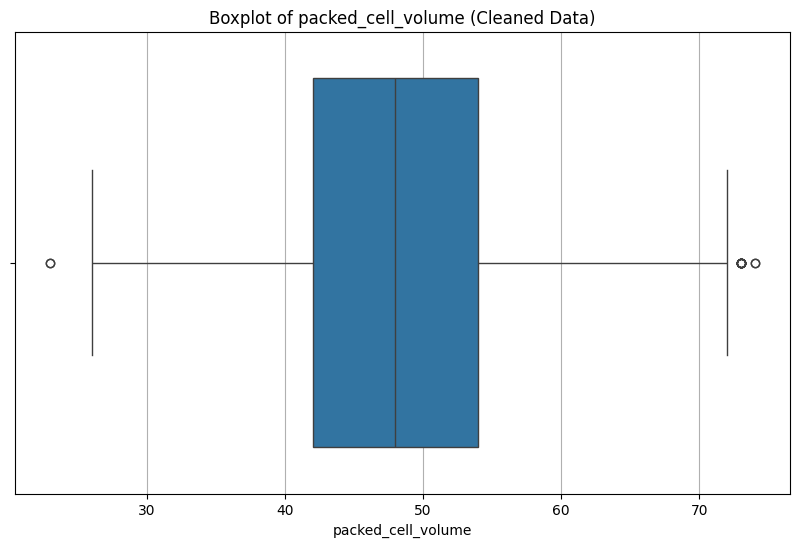

Feature: packed_cell_volume
  Lower Bound: 24.0
  Upper Bound: 72.0
  Outlier Values:
124     73.0
144     73.0
181     73.0
198     73.0
247     23.0
318     73.0
459     73.0
652     73.0
773     73.0
805     74.0
845     23.0
944     74.0
1058    73.0
1068    73.0
1183    73.0




In [ ]:
check = ['rectal_temp', 'abdomo_protein', 'packed_cell_volume'] # list of my problematic features

for i in check:
    Q1 = data_cleaned[i].quantile(0.25)
    Q3 = data_cleaned[i].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data_cleaned[(data_cleaned[i] < lower_bound) | (data_cleaned[i] > upper_bound)][i]

    # box plotting
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=data_cleaned, x=i)
    plt.title(f"Boxplot of {i} (Cleaned Data)")
    plt.xlabel(i)
    plt.grid(axis='x')
    plt.show()

    # Print outlier details
    print(f"Feature: {i}")
    print(f"  Lower Bound: {lower_bound}")
    print(f"  Upper Bound: {upper_bound}")
    print(f"  Outlier Values:")
    print(outliers.to_string(index=True)) # so i can actually see the remaining outlier values
    print("\n")

> After checking what outliers remained, they were all within 1 unit of the lower or upper bound. I could make my bounds stricter, but that will remove data, and my data has already been greatly reduced. Since i checked my outliers and i don't believe they will significatly impact my model, **I am making the decision to keep them**.



**Now that the dataset is finally clean, lets scale the numeric features**

In [ ]:
scaler = MinMaxScaler()
data_cleaned[num_cols] = scaler.fit_transform(data_cleaned[num_cols])

#checking
print(data_cleaned[num_cols].describe())

       rectal_temp        pulse  respiratory_rate  nasogastric_reflux_ph  \
count  1035.000000  1035.000000       1035.000000            1035.000000   
mean      0.492874     0.351721          0.328452               0.503560   
std       0.192339     0.200566          0.208122               0.294883   
min       0.000000     0.000000          0.000000               0.000000   
25%       0.375000     0.169231          0.137931               0.153846   
50%       0.500000     0.323077          0.275862               0.538462   
75%       0.593750     0.507692          0.482759               0.692308   
max       1.000000     1.000000          1.000000               1.000000   

       packed_cell_volume  abdomo_protein  
count         1035.000000     1035.000000  
mean             0.498503        0.420208  
std              0.191929        0.189374  
min              0.000000        0.000000  
25%              0.372549        0.267606  
50%              0.490196        0.380282  
75%    

## **Machine Learning**

### **Problem Formulation**

In [ ]:
data_cleaned.drop(columns=['id'], inplace= True) # prepping for model
data_cleaned.columns

Index(['surgery', 'age', 'rectal_temp', 'pulse', 'respiratory_rate',
       'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane',
       'capillary_refill_time', 'pain', 'nasogastric_tube',
       'nasogastric_reflux', 'nasogastric_reflux_ph', 'packed_cell_volume',
       'abdomo_appearance', 'abdomo_protein', 'outcome'],
      dtype='object')

In [ ]:
# one hot encoding cat cols and mapping the outcome

print("Original Columns:")
print(data_cleaned.columns)

outcome_mapping = {'lived': 0, 'died': 1, 'euthanized': 2}
data_cleaned['outcome'] = data_cleaned['outcome'].map(outcome_mapping)

# store the outcome before one hot encoding
outcome = data_cleaned['outcome']

data_cleaned = pd.get_dummies(data_cleaned, columns=cat_cols)

print("\nOne-Hot Encoded Columns:")
print(data_cleaned.columns)



Original Columns:
Index(['surgery', 'age', 'rectal_temp', 'pulse', 'respiratory_rate',
       'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane',
       'capillary_refill_time', 'pain', 'nasogastric_tube',
       'nasogastric_reflux', 'nasogastric_reflux_ph', 'packed_cell_volume',
       'abdomo_appearance', 'abdomo_protein', 'outcome'],
      dtype='object')

One-Hot Encoded Columns:
Index(['rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph',
       'packed_cell_volume', 'abdomo_protein', 'surgery_no', 'surgery_yes',
       'age_adult', 'age_young', 'temp_of_extremities_cold',
       'temp_of_extremities_cool', 'temp_of_extremities_normal',
       'temp_of_extremities_warm', 'peripheral_pulse_absent',
       'peripheral_pulse_increased', 'peripheral_pulse_normal',
       'peripheral_pulse_reduced', 'mucous_membrane_bright_pink',
       'mucous_membrane_bright_red', 'mucous_membrane_dark_cyanotic',
       'mucous_membrane_normal_pink', 'mucous_membrane_pale_cy

In [ ]:
# defing feature and target for train test split
X = data_cleaned.drop(columns=['outcome_0', 'outcome_1', 'outcome_2'])
y = outcome

In [ ]:
# splitting the cleaned data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) # using stratify bc outcome is imbalanced

### **Train ML Algorithm**

In [ ]:
# creating the random forrest model
rf_model = RandomForestClassifier()

# training
rf_model.fit(X_train, y_train)

# making predictions
y_pred_rf = rf_model.predict(X_test)

# evaluation
print("Random Forest Classifier Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Average F1 score:", f1_score(y_test, y_pred_rf, average='weighted'))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Classifier Results:
Accuracy: 0.6714975845410628
Average F1 score: 0.671079524340394

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.72      0.71       103
           1       0.63      0.63      0.63        63
           2       0.64      0.61      0.62        41

    accuracy                           0.67       207
   macro avg       0.66      0.65      0.66       207
weighted avg       0.67      0.67      0.67       207


Confusion Matrix:
[[74 20  9]
 [18 40  5]
 [13  3 25]]


In [ ]:
# creating xgb model
xgb_model = XGBClassifier()

# training
xgb_model.fit(X_train, y_train)

# making predictions
y_pred_xgb = xgb_model.predict(X_test)

# evaluation
print("\nXGBoost Classifier Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Average F1 score:", f1_score(y_test, y_pred_xgb, average='weighted'))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))



XGBoost Classifier Results:
Accuracy: 0.6956521739130435
Average F1 score: 0.6953709935537907

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74       103
           1       0.70      0.63      0.67        63
           2       0.61      0.66      0.64        41

    accuracy                           0.70       207
   macro avg       0.68      0.68      0.68       207
weighted avg       0.70      0.70      0.70       207


Confusion Matrix:
[[77 14 12]
 [18 40  5]
 [11  3 27]]


In [ ]:
# gridsearch cv for both models to see if can get better results


# for rf
param_grid = {
    'n_estimators': [100, 200, 300], # num of trees
    'max_depth': [None, 10, 20], #max depth of trees
    'min_samples_split': [2, 5, 10], #min samples required to split node
    'min_samples_leaf': [1, 2, 4], #min samples required to be at leaf node
}

grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_grid,
    scoring='f1_macro',  # optimizing for f1 score cos thats my main metric
    cv=5 # 5 fold cv
)

grid_search_rf.fit(X_train, y_train)
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)

best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)

# for xgb
param_grid_xgb = {
    'n_estimators': [100, 200, 300], # num of boosting rounds
    'max_depth': [3, 6, 10], # max depth of each tree
    'learning_rate': [0.01, 0.1, 0.2], # to prevent overfitting
    'subsample': [0.8, 1], #fraction of samples used for each boosting round
    'colsample_bytree': [0.8, 1], #fraction of samples usef for each tree
}

grid_search_xgb = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    param_grid=param_grid_xgb,
    scoring='f1_macro', # optimizing for f1 score cos thats my main metric
    cv=5
)

grid_search_xgb.fit(X_train, y_train)
print("Best Parameters for XGBoost:", grid_search_xgb.best_params_)

best_xgb_model = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)



Best Parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:09:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:09:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:09:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:09:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:09:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Best Parameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


In [ ]:
# rf best params
best_rf_model = RandomForestClassifier(
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=10,
    n_estimators=300,
    random_state=42,
    class_weight='balanced'  # Include this if the classes are imbalanced
)

# xgb best params
best_xgb_model = XGBClassifier(
    colsample_bytree=0.8,
    learning_rate=0.01,
    max_depth=3,
    n_estimators=200,
    subsample=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)


# saving rf
joblib.dump(best_rf_model, 'best_rf_model.pkl')

# saving xgb
joblib.dump(best_xgb_model, 'best_xgb_model.pkl')

print("Models saved successfully!")



Models saved successfully!


Best Parameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

Best Parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}


##**Applying my final models to test.csv**

In [612]:
final_test = pd.read_csv('test.csv')
final_test.head()

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,1235,no,adult,534053,38.6,40.0,20.0,normal,normal,normal_pink,...,distend_small,42.0,7.5,clear,2.3,no,0,0,0,no
1,1236,yes,adult,528469,38.2,112.0,48.0,cool,reduced,bright_pink,...,distend_small,44.0,6.0,serosanguious,2.6,no,2208,0,0,yes
2,1237,yes,adult,528178,37.7,66.0,12.0,cool,normal,bright_red,...,distend_small,31.5,6.0,cloudy,1.6,yes,2205,0,0,yes
3,1238,no,adult,534784,37.1,88.0,20.0,cool,reduced,pale_cyanotic,...,distend_large,75.0,81.0,NaN,1.0,yes,1400,0,0,no
4,1239,yes,adult,529840,38.3,50.0,12.0,NaN,normal,bright_pink,...,distend_small,37.0,6.8,cloudy,2.6,yes,2208,0,0,yes


> For my test.csv i cant get rid of any rows because kaggle requires all 824 rows and after getting rid of outliers, i have less than 700, so i will be doing very minor preprocessing



In [613]:
# unmapping
outcome_mapping_reverse = {0: 'lived', 1: 'died', 2: 'euthanized'}

#  weak cols
to_drop = ['hospital_number', 'total_protein', 'lesion_1', 'lesion_2', 'lesion_3',
           'abdominal_distention', 'rectal_exam_feces', 'abdomen', 'surgical_lesion',
           'cp_data', 'peristalsis']

# dropping the weak cols
final_test = final_test.drop(columns= to_drop)

# imputing missing vals with mode and unknown like in test.csv
mode_features = ['temp_of_extremities', 'peripheral_pulse', 'mucous_membrane',
                 'capillary_refill_time', 'pain', 'abdomo_appearance']
for feature in mode_features:
    final_test[feature] = final_test[feature].fillna(final_test[feature].mode()[0])

final_test['nasogastric_tube'] = final_test['nasogastric_tube'].fillna('Unknown')
final_test['nasogastric_reflux'] = final_test['nasogastric_reflux'].fillna('Unknown')

# one hot coding for model
cat_cols = final_test.select_dtypes(include=['object']).columns
id_column = final_test['id']  #savinf id col for sample submission

test_data = pd.get_dummies(final_test, columns=cat_cols)

In [614]:
#aligning cols with training data
trained_columns = [col for col in X_train.columns] # Use feature columns from training dataset
for col in trained_columns:
    if col not in test_data.columns:
        test_data[col] = 0

# making sure order matches
X_test = test_data = test_data.reindex(columns=trained_columns, fill_value=0)

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
joblib.dump(rf_model, 'best_rf_model.pkl') # using my best rf model

xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
joblib.dump(xgb_model, 'best_xgb_model.pkl')# using my best xgb model

# loading them
rf_model = joblib.load('best_rf_model.pkl')
xgb_model = joblib.load('best_xgb_model.pkl')

# making predictions
rf_predictions = rf_model.predict(X_test)
xgb_predictions = xgb_model.predict(X_test)

# unmapping
rf_predictions = [outcome_mapping_reverse[pred] for pred in rf_predictions]
xgb_predictions = [outcome_mapping_reverse[pred] for pred in xgb_predictions]

# making submission files
rf_submission = pd.DataFrame({'id': id_column, 'outcome': rf_predictions})
xgb_submission = pd.DataFrame({'id': id_column, 'outcome': xgb_predictions})

rf_submission.to_csv('rf_submission.csv', index=False)
xgb_submission.to_csv('xgb_submission.csv', index=False)

#checking
print("Submissions created: rf_submission.csv and xgb_submission.csv")



Submissions created: rf_submission.csv and xgb_submission.csv


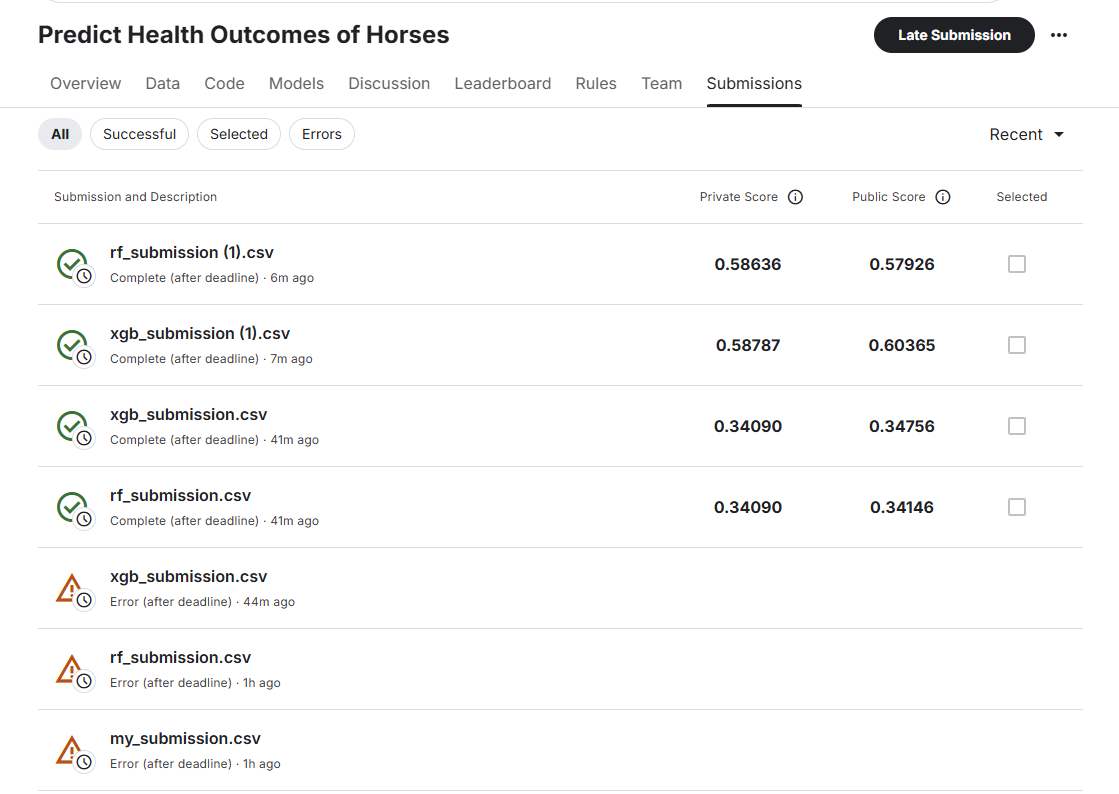

#After submitting to kaggle, we can clearly see that xgboost did better.**The highest score in the competition was .78** and **my personal best was .60**.